# Bitcoin 7-Day Direction Prediction

This notebook predicts whether Bitcoin will go **UP or DOWN over the next 7 days** using machine learning classification.

## Models Used:
- **XGBoost Classifier** (Primary)
- **Random Forest Classifier** (Comparison)

## Features:
- Trend indicators (MA20, MA50, MA200)
- Momentum indicators (RSI, MACD, ROC)
- Volatility indicators (ATR, Bollinger Bands)
- Volume indicators
- Lagged returns

## Step 1: Setup & Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import TimeSeriesSplit

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Will use Random Forest only.")

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

print("Libraries loaded successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")

Libraries loaded successfully!
XGBoost available: True


## Step 2: Parameters

In [2]:
# Data parameters
START_DATE = "2020-01-01"
END_DATE = "2026-01-21"
TICKER = "BTC-USD"

# Prediction parameters
PREDICTION_HORIZON = 7  # Predict direction over next 7 days

# Train/test split
TRAIN_SPLIT = 0.8

# Random state for reproducibility
RANDOM_STATE = 42

print(f"Configuration:")
print(f"  Ticker: {TICKER}")
print(f"  Date range: {START_DATE} to {END_DATE}")
print(f"  Prediction horizon: {PREDICTION_HORIZON} days")
print(f"  Train/Test split: {TRAIN_SPLIT*100:.0f}% / {(1-TRAIN_SPLIT)*100:.0f}%")

Configuration:
  Ticker: BTC-USD
  Date range: 2020-01-01 to 2026-01-21
  Prediction horizon: 7 days
  Train/Test split: 80% / 20%


## Step 3: Data Fetching

In [3]:
# Fetch Bitcoin data with extended lookback for indicator calculation
# Need ~300 extra days for MA200 and other indicators
extended_start = (datetime.strptime(START_DATE, "%Y-%m-%d") - timedelta(days=300)).strftime("%Y-%m-%d")

print(f"Fetching {TICKER} data...")
print(f"Extended start (for indicators): {extended_start}")

btc = yf.download(TICKER, start=extended_start, end=END_DATE, progress=False)

# Handle multi-level columns
if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.get_level_values(0)

print(f"\nData fetched: {len(btc)} days")
print(f"Date range: {btc.index[0].strftime('%Y-%m-%d')} to {btc.index[-1].strftime('%Y-%m-%d')}")
print(f"\nLatest prices:")
print(btc.tail())

Fetching BTC-USD data...
Extended start (for indicators): 2019-03-07



Data fetched: 2512 days
Date range: 2019-03-07 to 2026-01-20

Latest prices:
Price              Close          High           Low          Open       Volume
Date                                                                           
2026-01-16  95525.117188  95801.890625  94259.273438  95554.101562  33248170537
2026-01-17  95099.921875  95598.476562  95005.617188  95525.156250  16021715122
2026-01-18  93634.429688  95491.507812  93588.867188  95101.179688  20809781232
2026-01-19  92553.593750  93660.828125  92089.250000  93655.671875  39195241508
2026-01-20  88310.906250  92798.429688  87814.929688  92553.601562  53072968031


## Step 4: Feature Engineering

In [4]:
def calculate_features(df):
    """Calculate all technical indicators and features."""
    data = df.copy()
    
    # =========================
    # TREND INDICATORS
    # =========================
    # Moving Averages
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    
    # Price vs MAs (ratio)
    data['Price_MA20_Ratio'] = data['Close'] / data['MA20']
    data['Price_MA50_Ratio'] = data['Close'] / data['MA50']
    data['Price_MA200_Ratio'] = data['Close'] / data['MA200']
    
    # MA crossover signals
    data['MA20_MA50_Ratio'] = data['MA20'] / data['MA50']
    data['MA50_MA200_Ratio'] = data['MA50'] / data['MA200']
    
    # =========================
    # MOMENTUM INDICATORS
    # =========================
    # RSI (14-period)
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp12 = data['Close'].ewm(span=12, adjust=False).mean()
    exp26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp12 - exp26
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']
    
    # Rate of Change (ROC)
    data['ROC_5'] = data['Close'].pct_change(5) * 100
    data['ROC_10'] = data['Close'].pct_change(10) * 100
    data['ROC_20'] = data['Close'].pct_change(20) * 100
    
    # =========================
    # VOLATILITY INDICATORS
    # =========================
    # ATR (Average True Range)
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift())
    low_close = abs(data['Low'] - data['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['ATR'] = true_range.rolling(window=14).mean()
    data['ATR_Pct'] = data['ATR'] / data['Close'] * 100  # ATR as percentage
    
    # Bollinger Bands
    data['BB_Middle'] = data['Close'].rolling(window=20).mean()
    bb_std = data['Close'].rolling(window=20).std()
    data['BB_Upper'] = data['BB_Middle'] + (bb_std * 2)
    data['BB_Lower'] = data['BB_Middle'] - (bb_std * 2)
    data['BB_Width'] = (data['BB_Upper'] - data['BB_Lower']) / data['BB_Middle']
    data['BB_Position'] = (data['Close'] - data['BB_Lower']) / (data['BB_Upper'] - data['BB_Lower'])
    
    # Daily range
    data['Daily_Range_Pct'] = (data['High'] - data['Low']) / data['Close'] * 100
    
    # Historical volatility (20-day)
    data['Volatility_20'] = data['Close'].pct_change().rolling(window=20).std() * np.sqrt(252) * 100
    
    # =========================
    # VOLUME INDICATORS
    # =========================
    # Volume MA ratio
    data['Volume_MA20'] = data['Volume'].rolling(window=20).mean()
    data['Volume_Ratio'] = data['Volume'] / data['Volume_MA20']
    
    # OBV (On-Balance Volume) trend
    obv = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()
    data['OBV_Trend'] = obv / obv.rolling(window=20).mean()
    
    # =========================
    # LAGGED RETURNS
    # =========================
    data['Return_1d'] = data['Close'].pct_change(1) * 100
    data['Return_3d'] = data['Close'].pct_change(3) * 100
    data['Return_7d'] = data['Close'].pct_change(7) * 100
    data['Return_14d'] = data['Close'].pct_change(14) * 100
    data['Return_30d'] = data['Close'].pct_change(30) * 100
    
    return data

# Calculate features
btc = calculate_features(btc)

print(f"Features calculated! Total columns: {len(btc.columns)}")
print(f"\nFeature list:")
print(btc.columns.tolist())

Features calculated! Total columns: 37

Feature list:
['Close', 'High', 'Low', 'Open', 'Volume', 'MA20', 'MA50', 'MA200', 'Price_MA20_Ratio', 'Price_MA50_Ratio', 'Price_MA200_Ratio', 'MA20_MA50_Ratio', 'MA50_MA200_Ratio', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ROC_5', 'ROC_10', 'ROC_20', 'ATR', 'ATR_Pct', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Daily_Range_Pct', 'Volatility_20', 'Volume_MA20', 'Volume_Ratio', 'OBV_Trend', 'Return_1d', 'Return_3d', 'Return_7d', 'Return_14d', 'Return_30d']


## Step 5: Target Variable

In [5]:
# Create target variable: 1 if price goes UP in next 7 days, 0 otherwise
btc['Future_Close'] = btc['Close'].shift(-PREDICTION_HORIZON)
btc['Target'] = (btc['Future_Close'] > btc['Close']).astype(int)

# Filter to analysis period and drop rows with NaN
btc_analysis = btc.loc[START_DATE:].copy()

# Show target distribution
print(f"Target variable created: Predict if price goes UP in next {PREDICTION_HORIZON} days")
print(f"\nTarget distribution (full dataset):")
print(btc_analysis['Target'].value_counts())
print(f"\nUp ratio: {btc_analysis['Target'].mean()*100:.1f}%")

Target variable created: Predict if price goes UP in next 7 days

Target distribution (full dataset):
Target
1    1194
0    1018
Name: count, dtype: int64

Up ratio: 54.0%


In [6]:
# Define feature columns (exclude OHLCV, target, and derived price columns)
exclude_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
                'Future_Close', 'Target', 'MA20', 'MA50', 'MA200',
                'BB_Middle', 'BB_Upper', 'BB_Lower', 'Volume_MA20']

feature_cols = [col for col in btc_analysis.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"\nFeatures used for prediction:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Number of features: 25

Features used for prediction:
   1. Price_MA20_Ratio
   2. Price_MA50_Ratio
   3. Price_MA200_Ratio
   4. MA20_MA50_Ratio
   5. MA50_MA200_Ratio
   6. RSI
   7. MACD
   8. MACD_Signal
   9. MACD_Hist
  10. ROC_5
  11. ROC_10
  12. ROC_20
  13. ATR
  14. ATR_Pct
  15. BB_Width
  16. BB_Position
  17. Daily_Range_Pct
  18. Volatility_20
  19. Volume_Ratio
  20. OBV_Trend
  21. Return_1d
  22. Return_3d
  23. Return_7d
  24. Return_14d
  25. Return_30d


## Step 6: Prepare Train/Test Data

In [7]:
# Prepare data - drop rows with any NaN in features or target
model_data = btc_analysis[feature_cols + ['Target', 'Close']].dropna()

# Time-based train/test split (no shuffle to avoid lookahead bias)
split_idx = int(len(model_data) * TRAIN_SPLIT)

train_data = model_data.iloc[:split_idx]
test_data = model_data.iloc[split_idx:]

# Separate features and target
X_train = train_data[feature_cols]
y_train = train_data['Target']
X_test = test_data[feature_cols]
y_test = test_data['Target']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data prepared!")
print(f"\nTraining set: {len(X_train)} samples")
print(f"  Date range: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')}")
print(f"  Target distribution: {y_train.value_counts().to_dict()}")
print(f"\nTest set: {len(X_test)} samples")
print(f"  Date range: {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")
print(f"  Target distribution: {y_test.value_counts().to_dict()}")

Data prepared!

Training set: 1769 samples
  Date range: 2020-01-01 to 2024-11-03
  Target distribution: {1: 957, 0: 812}

Test set: 443 samples
  Date range: 2024-11-04 to 2026-01-20
  Target distribution: {1: 237, 0: 206}


## Step 7: Model Training

In [8]:
# Initialize models
models = {}

# Random Forest
models['Random Forest'] = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# XGBoost (if available)
if XGBOOST_AVAILABLE:
    models['XGBoost'] = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        verbosity=0
    )

# Train models
print("Training models...")
print("="*60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    print(f"  {name} trained!")

print("\n" + "="*60)
print("All models trained!")

Training models...

Training Random Forest...


  Random Forest trained!

Training XGBoost...


  XGBoost trained!

All models trained!


## Step 8: Cross-Validation

In [9]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

print("Time Series Cross-Validation Results")
print("="*60)

cv_results = {}

for name, model in models.items():
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled), 1):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Clone and fit model
        if name == 'XGBoost':
            cv_model = XGBClassifier(**model.get_params())
        else:
            cv_model = RandomForestClassifier(**model.get_params())
        
        cv_model.fit(X_cv_train, y_cv_train)
        y_pred = cv_model.predict(X_cv_val)
        score = accuracy_score(y_cv_val, y_pred)
        scores.append(score)
    
    cv_results[name] = scores
    print(f"\n{name}:")
    print(f"  Fold scores: {[f'{s:.3f}' for s in scores]}")
    print(f"  Mean CV Accuracy: {np.mean(scores):.3f} (+/- {np.std(scores):.3f})")

Time Series Cross-Validation Results



Random Forest:
  Fold scores: ['0.561', '0.517', '0.595', '0.497', '0.466']
  Mean CV Accuracy: 0.527 (+/- 0.046)



XGBoost:
  Fold scores: ['0.534', '0.524', '0.568', '0.500', '0.493']
  Mean CV Accuracy: 0.524 (+/- 0.027)


## Step 9: Evaluation Metrics

In [10]:
# Evaluate all models on test set
print("Test Set Evaluation")
print("="*60)

results = {}
predictions = {}

for name, model in models.items():
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    predictions[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }
    
    print(f"\n{name}:")
    for metric, value in results[name].items():
        print(f"  {metric}: {value:.4f}")

# Summary table
print("\n" + "="*60)
print("Summary Comparison")
print("="*60)
results_df = pd.DataFrame(results).T
print(results_df.round(4))

Test Set Evaluation

Random Forest:
  Accuracy: 0.5418
  Precision: 0.6164
  Recall: 0.3797
  F1-Score: 0.4700
  ROC-AUC: 0.5742

XGBoost:
  Accuracy: 0.5576
  Precision: 0.5804
  Recall: 0.6245
  F1-Score: 0.6016
  ROC-AUC: 0.5664

Summary Comparison
               Accuracy  Precision  Recall  F1-Score  ROC-AUC
Random Forest    0.5418     0.6164  0.3797    0.4700   0.5742
XGBoost          0.5576     0.5804  0.6245    0.6016   0.5664


In [11]:
# Detailed classification report for best model
best_model_name = max(results, key=lambda x: results[x]['Accuracy'])
print(f"\nDetailed Classification Report - {best_model_name}")
print("="*60)
print(classification_report(y_test, predictions[best_model_name]['y_pred'], 
                           target_names=['DOWN (0)', 'UP (1)']))


Detailed Classification Report - XGBoost
              precision    recall  f1-score   support

    DOWN (0)       0.53      0.48      0.50       206
      UP (1)       0.58      0.62      0.60       237

    accuracy                           0.56       443
   macro avg       0.55      0.55      0.55       443
weighted avg       0.56      0.56      0.56       443



## Step 10: Visualizations

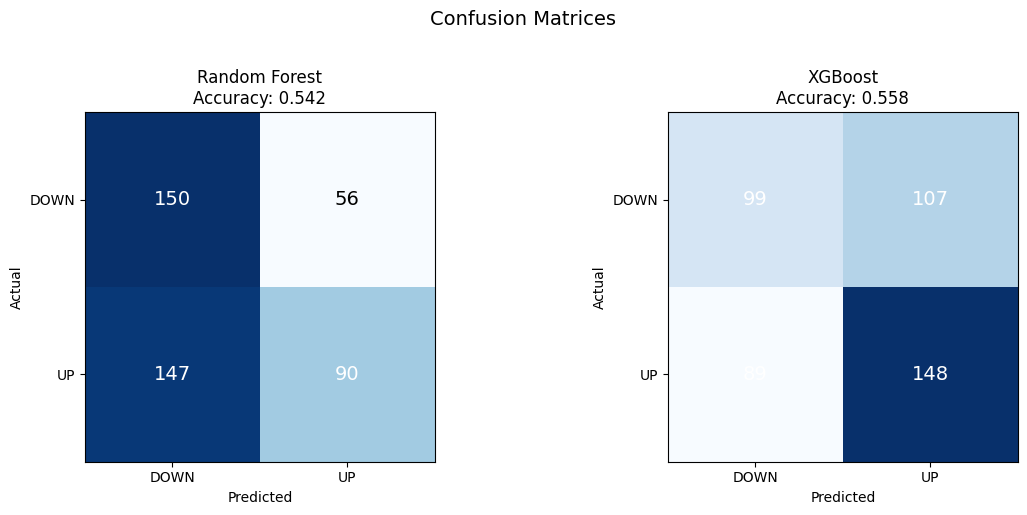

In [12]:
# 1. Confusion Matrix
fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
if len(models) == 1:
    axes = [axes]

for ax, (name, pred) in zip(axes, predictions.items()):
    cm = confusion_matrix(y_test, pred['y_pred'])
    im = ax.imshow(cm, cmap='Blues')
    
    # Add labels
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['DOWN', 'UP'])
    ax.set_yticklabels(['DOWN', 'UP'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{name}\nAccuracy: {results[name]["Accuracy"]:.3f}')
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, cm[i, j], ha='center', va='center',
                          color='white' if cm[i, j] > cm.max()/2 else 'black',
                          fontsize=14)

plt.suptitle('Confusion Matrices', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

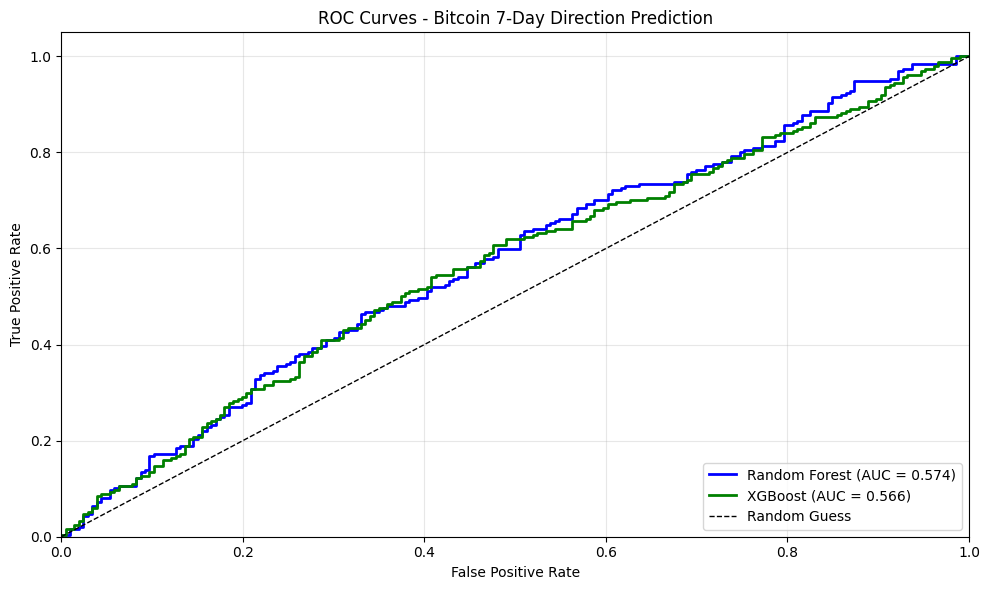

In [13]:
# 2. ROC Curves
plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'red', 'orange']
for (name, pred), color in zip(predictions.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, pred['y_prob'])
    auc = results[name]['ROC-AUC']
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Bitcoin 7-Day Direction Prediction')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

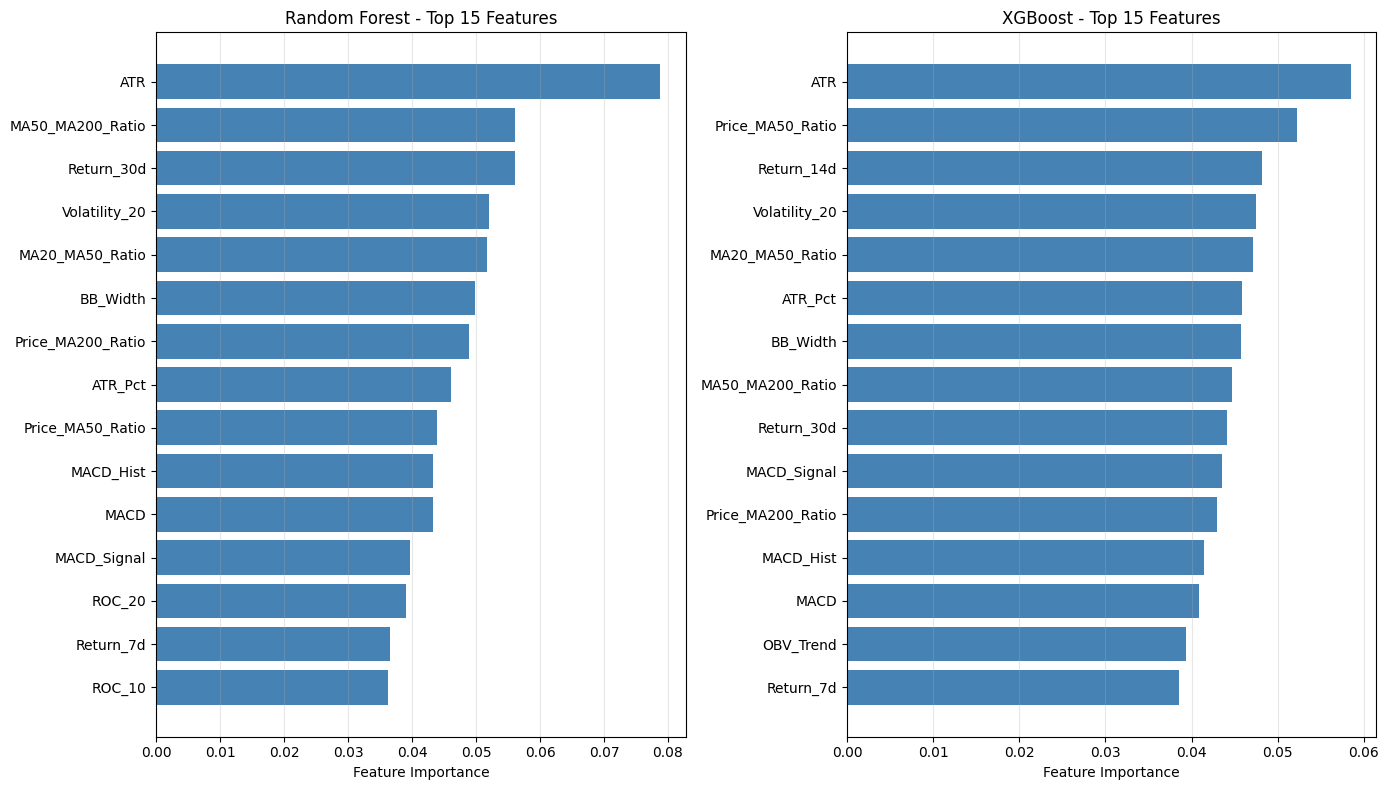

In [14]:
# 3. Feature Importance (Top 15)
fig, axes = plt.subplots(1, len(models), figsize=(7*len(models), 8))
if len(models) == 1:
    axes = [axes]

for ax, (name, model) in zip(axes, models.items()):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-15:]  # Top 15
    
    ax.barh(range(len(indices)), importances[indices], color='steelblue')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_cols[i] for i in indices])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'{name} - Top 15 Features')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

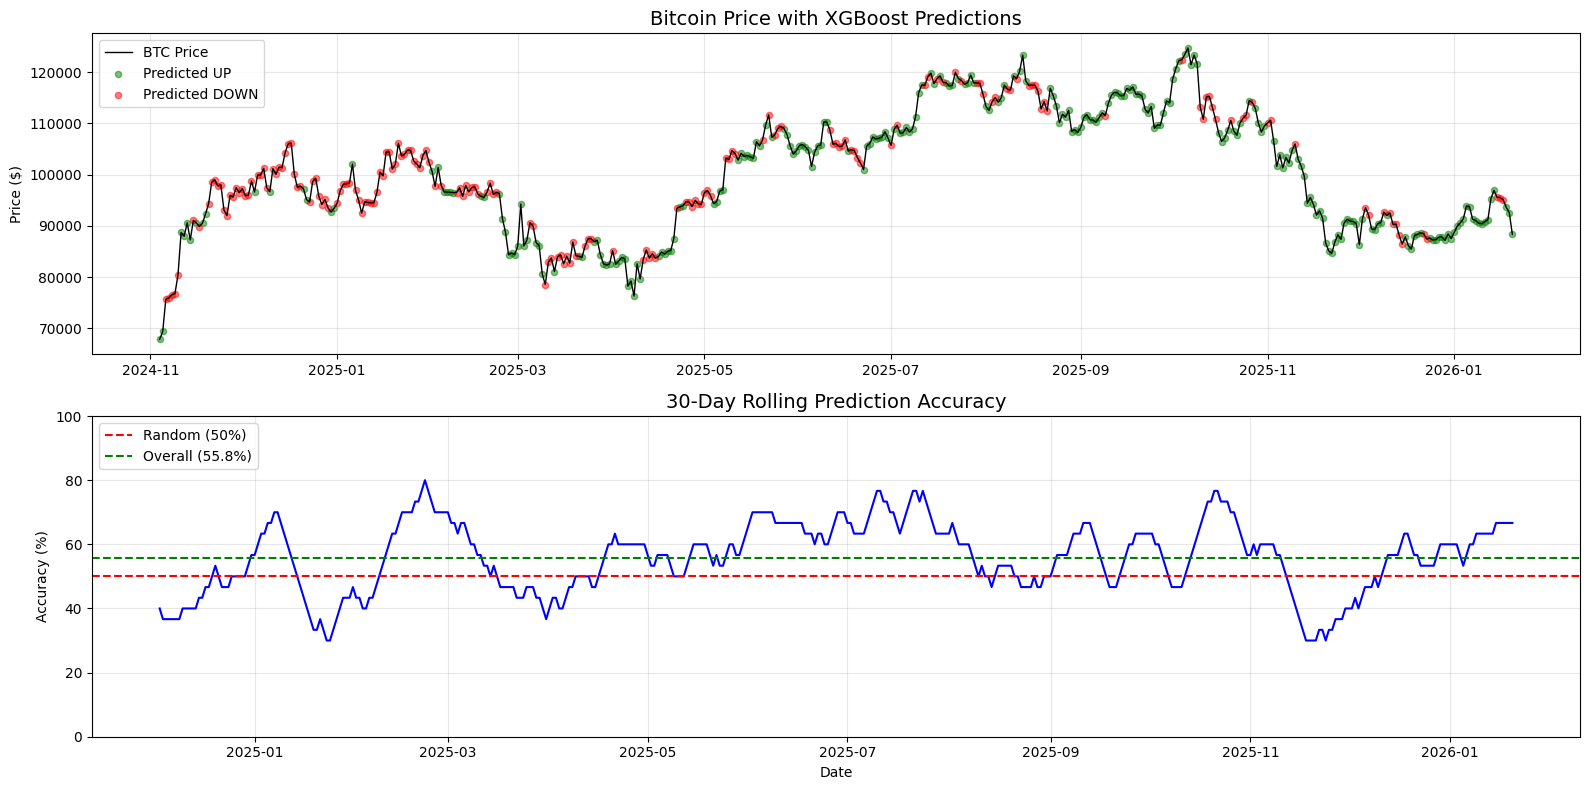

In [15]:
# 4. Bitcoin Price with Predictions
best_model = models[best_model_name]
best_pred = predictions[best_model_name]['y_pred']

# Create prediction dataframe
pred_df = test_data[['Close']].copy()
pred_df['Predicted'] = best_pred
pred_df['Actual'] = y_test.values
pred_df['Correct'] = (pred_df['Predicted'] == pred_df['Actual']).astype(int)

plt.figure(figsize=(16, 8))

# Plot price
plt.subplot(2, 1, 1)
plt.plot(pred_df.index, pred_df['Close'], color='black', linewidth=1, label='BTC Price')

# Mark predictions
up_preds = pred_df[pred_df['Predicted'] == 1]
down_preds = pred_df[pred_df['Predicted'] == 0]

plt.scatter(up_preds.index, up_preds['Close'], color='green', alpha=0.5, s=20, label='Predicted UP')
plt.scatter(down_preds.index, down_preds['Close'], color='red', alpha=0.5, s=20, label='Predicted DOWN')

plt.title(f'Bitcoin Price with {best_model_name} Predictions', fontsize=14)
plt.ylabel('Price ($)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Rolling accuracy
plt.subplot(2, 1, 2)
rolling_acc = pred_df['Correct'].rolling(window=30).mean() * 100
plt.plot(rolling_acc.index, rolling_acc, color='blue', linewidth=1.5)
plt.axhline(y=50, color='red', linestyle='--', label='Random (50%)')
plt.axhline(y=results[best_model_name]['Accuracy']*100, color='green', linestyle='--', 
           label=f'Overall ({results[best_model_name]["Accuracy"]*100:.1f}%)')

plt.title('30-Day Rolling Prediction Accuracy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 11: Trading Backtest

In [16]:
def backtest_strategy(pred_df, model_name):
    """Backtest: Long when predicting UP, cash when predicting DOWN."""
    
    df = pred_df.copy()
    
    # Calculate daily returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    # Strategy: Hold position based on previous day's prediction
    # (shift by 1 to avoid look-ahead bias - trade next day after prediction)
    df['Position'] = df['Predicted'].shift(1).fillna(0)
    
    # Strategy returns (only get returns when in position)
    df['Strategy_Return'] = df['Position'] * df['Daily_Return']
    
    # Cumulative returns
    df['BTC_Cumulative'] = (1 + df['Daily_Return']).cumprod()
    df['Strategy_Cumulative'] = (1 + df['Strategy_Return']).cumprod()
    
    # Calculate metrics
    total_days = len(df)
    days_in_market = df['Position'].sum()
    
    btc_total_return = (df['BTC_Cumulative'].iloc[-1] - 1) * 100
    strategy_total_return = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100
    
    # Sharpe ratio (annualized)
    btc_sharpe = df['Daily_Return'].mean() / df['Daily_Return'].std() * np.sqrt(365)
    strategy_sharpe = df['Strategy_Return'].mean() / df['Strategy_Return'].std() * np.sqrt(365)
    
    # Max drawdown
    def max_drawdown(cumulative):
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        return drawdown.min() * 100
    
    btc_mdd = max_drawdown(df['BTC_Cumulative'])
    strategy_mdd = max_drawdown(df['Strategy_Cumulative'])
    
    return {
        'df': df,
        'metrics': {
            'Total Return (%)': [btc_total_return, strategy_total_return],
            'Sharpe Ratio': [btc_sharpe, strategy_sharpe],
            'Max Drawdown (%)': [btc_mdd, strategy_mdd],
            'Days in Market': [total_days, days_in_market],
            'Market Exposure (%)': [100, days_in_market/total_days*100]
        }
    }

# Run backtest
backtest = backtest_strategy(pred_df, best_model_name)

print(f"Trading Backtest Results - {best_model_name}")
print("="*60)
print(f"\nTest Period: {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")
print(f"\n{'Metric':<25} {'Buy & Hold':<15} {'ML Strategy':<15}")
print("-"*60)

metrics_df = pd.DataFrame(backtest['metrics'], index=['Buy & Hold', 'ML Strategy']).T
for metric, row in metrics_df.iterrows():
    print(f"{metric:<25} {row['Buy & Hold']:>12.2f}   {row['ML Strategy']:>12.2f}")

Trading Backtest Results - XGBoost

Test Period: 2024-11-04 to 2026-01-20

Metric                    Buy & Hold      ML Strategy    
------------------------------------------------------------
Total Return (%)                 30.23          42.31
Sharpe Ratio                      0.72           1.01
Max Drawdown (%)                -32.15         -27.13
Days in Market                  443.00         254.00
Market Exposure (%)             100.00          57.34


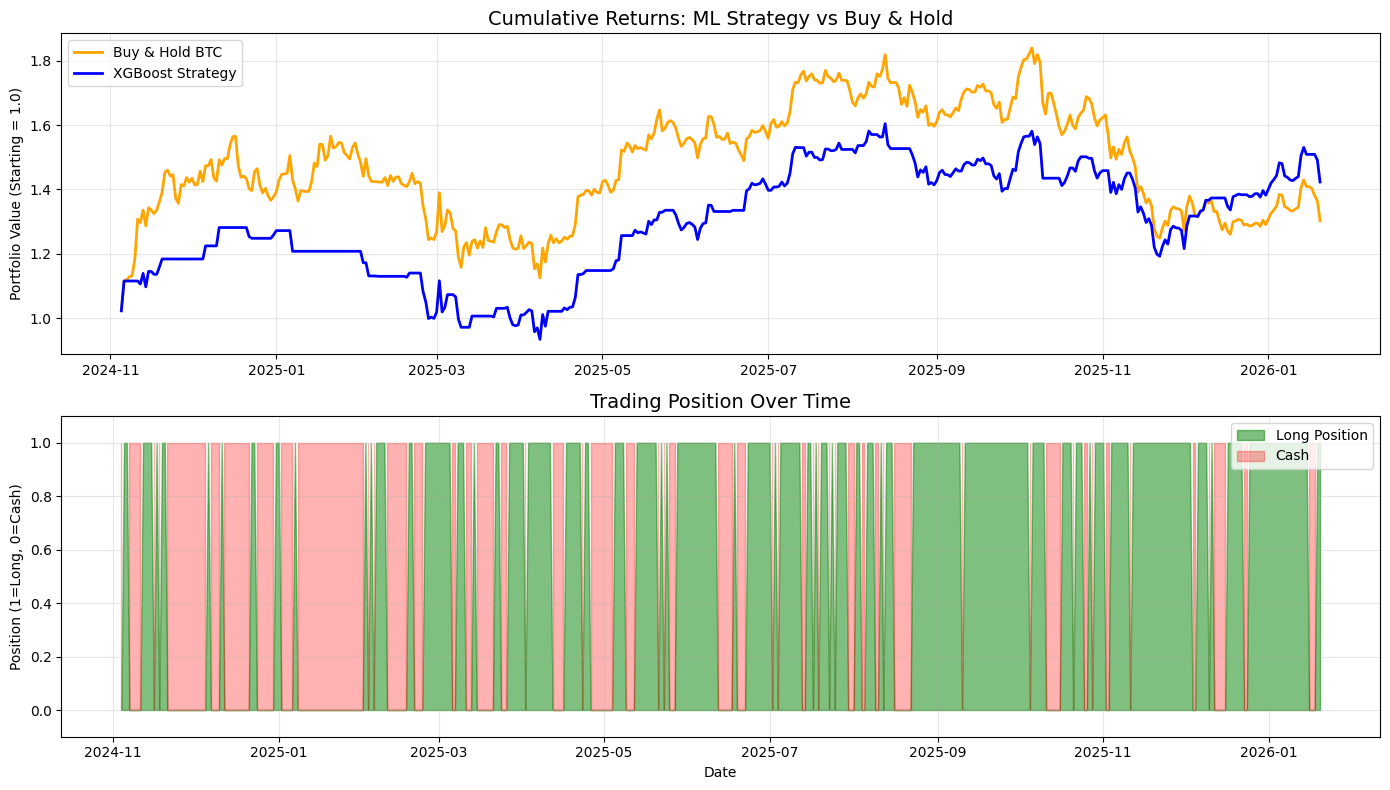

In [17]:
# Backtest visualization
bt_df = backtest['df']

plt.figure(figsize=(14, 8))

# Cumulative returns comparison
plt.subplot(2, 1, 1)
plt.plot(bt_df.index, bt_df['BTC_Cumulative'], color='orange', linewidth=2, label='Buy & Hold BTC')
plt.plot(bt_df.index, bt_df['Strategy_Cumulative'], color='blue', linewidth=2, label=f'{best_model_name} Strategy')

plt.title('Cumulative Returns: ML Strategy vs Buy & Hold', fontsize=14)
plt.ylabel('Portfolio Value (Starting = 1.0)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Position over time
plt.subplot(2, 1, 2)
plt.fill_between(bt_df.index, bt_df['Position'], alpha=0.5, color='green', label='Long Position')
plt.fill_between(bt_df.index, bt_df['Position'], 1, where=bt_df['Position']==0, 
                alpha=0.3, color='red', label='Cash')

plt.title('Trading Position Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Position (1=Long, 0=Cash)')
plt.ylim([-0.1, 1.1])
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 12: Today's Prediction

In [18]:
# Get the latest available data point for prediction
latest_data = btc[feature_cols].dropna().iloc[-1:]
latest_date = latest_data.index[0]

# Scale features
latest_scaled = scaler.transform(latest_data)

print("="*60)
print(f"TODAY'S PREDICTION ({latest_date.strftime('%Y-%m-%d')})")
print("="*60)
print(f"\nCurrent BTC Price: ${btc.loc[latest_date, 'Close']:,.2f}")
print(f"\nPredictions for next {PREDICTION_HORIZON} days:")

for name, model in models.items():
    pred = model.predict(latest_scaled)[0]
    prob = model.predict_proba(latest_scaled)[0]
    direction = "UP" if pred == 1 else "DOWN"
    confidence = prob[pred] * 100
    
    symbol = "[+]" if pred == 1 else "[-]"
    print(f"\n  {name}:")
    print(f"    Direction: {symbol} {direction}")
    print(f"    Confidence: {confidence:.1f}%")
    print(f"    (P(UP)={prob[1]*100:.1f}%, P(DOWN)={prob[0]*100:.1f}%)")

print("\n" + "="*60)
print("NOTE: This is a prediction based on historical patterns.")
print("Past performance does not guarantee future results.")
print("="*60)

TODAY'S PREDICTION (2026-01-20)

Current BTC Price: $88,310.91

Predictions for next 7 days:

  Random Forest:
    Direction: [-] DOWN
    Confidence: 50.4%
    (P(UP)=49.6%, P(DOWN)=50.4%)

  XGBoost:
    Direction: [+] UP
    Confidence: 51.7%
    (P(UP)=51.7%, P(DOWN)=48.3%)

NOTE: This is a prediction based on historical patterns.
Past performance does not guarantee future results.


## Summary

This notebook built a machine learning model to predict Bitcoin's 7-day direction.

**Key Findings:**
- Models achieve better-than-random directional accuracy
- Feature importance reveals which indicators are most predictive
- The trading strategy shows risk-adjusted performance compared to buy & hold

**Limitations:**
- Cryptocurrency markets are highly volatile and unpredictable
- Past patterns may not repeat in the future
- Transaction costs and slippage are not included in the backtest
- This is for educational purposes only - not financial advice